# FRICOSIPY Result Viewer

In [1]:
# Load Python Modules
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams["figure.figsize"] = (12, 6)

In [ ]:
filename = '<output.nc>' # Specify the output NetCDF dataset filename

In [ ]:
# Loads the NetCDF file using the Xarray package.
data_path = './data/output/'
ds = xr.open_dataset(os.path.join(data_path,filename))

In [2]:
ds = xr.open_dataset('Output_Colle_Gnifetti_1999-2025_FRICOSIPY_V1_3.nc')

In [6]:
x = 2633820
y = 1086590

In [7]:
ds # Opens the Xarray interactive dataset viewer, showing the dataframe co-ordinates, variables and attributes (parameters).

<xarray.Dataset> Size: 2GB
Dimensions:                    (y: 1, x: 1, time: 78160, layer: 500)
Coordinates:
  * y                          (y) int64 8B 1086590
  * x                          (x) int64 8B 2633820
  * time                       (time) datetime64[ns] 625kB 1999-01-01T02:00:0...
  * layer                      (layer) int64 4kB 0 1 2 3 4 ... 496 497 498 499
Data variables: (12/57)
    ELEVATION                  (y, x) float64 8B ...
    MASK                       (y, x) float64 8B ...
    SLOPE                      (y, x) float64 8B ...
    ASPECT                     (y, x) float64 8B ...
    EASTING                    (y, x) float64 8B ...
    NORTHING                   (y, x) float64 8B ...
    ...                         ...
    LAYER_POROSITY             (time, y, x, layer) float32 156MB ...
    LAYER_ICE_FRACTION         (time, y, x, layer) float32 156MB ...
    LAYER_IRR_WATER            (time, y, x, layer) float32 156MB ...
    LAYER_REFREEZE             (time, y, x, layer) float32 156MB ...
    LAYER_HYDRO_YEAR           (time, y, x, layer) float32 156MB ...
    LAYER_GRAIN_SIZE           (time, y, x, layer) float32 156MB ...
Attributes: (12/79)
    Compression_level:                              2
    Full_field:                                     True
    Albedo_method:                                  Bougamont05
    Dry_densification_method:                       Ligtenberg11
    Penetrating_radiation_method:                   Bintanja95
    Roughness_method:                               constant
    ...                                             ...
    R_watervapour:                                  462.0
    R_dryair:                                       287.0
    Optical_depth:                                  1.6
    exp_aerosol:                                    0.97
    Stefan-Boltzmann_constant:                      5.67e-08
    Zero_temperature:                               273.16

## Point Surface Energy Balance (SEB) 
Produces a graphical representation of the surface energy balance for a single spatial node (expressed as mean monthly energy fluxes).

In [8]:
def create_point_surface_energy_balance_figure(ds, x, y):
    """ Produces a graphical representation of the surface energy balance for a single spatial node 
    (expressed as mean monthly energy fluxes).
    
    Arguments:

        ds    ::    Loaded Xarray dataset (FRICOSIPY Output NetCDF file).
        x     ::    Easting (X-coordinate) of chosen spatial node.
        y     ::    Northing (Y-coordinate) of chosen spatial node.

    Returns:

        Figure: Point Surface Energy Balance (SEB)
    
    """

    # Calculate the mean annual energy fluxes:
    SHORTWAVE = ds.SHORTWAVE.sel(x = x, y = y).groupby("time.month").mean("time")
    SENSIBLE = ds.SENSIBLE.sel(x = x, y = y).groupby("time.month").mean("time")
    SUBSURFACE = ds.SUBSURFACE.sel(x = x, y = y).groupby("time.month").mean("time")
    MELT = ds.MELT_ENERGY.sel(x = x, y = y).groupby("time.month").mean("time") * -1
    LATENT = ds.LATENT.sel(x = x, y = y).groupby("time.month").mean("time")
    LONGWAVE = ds.LONGWAVE.sel(x = x, y = y).groupby("time.month").mean("time")
    RAIN_HEAT = ds.RAIN_HEAT_FLUX.sel(x = x, y = y).groupby("time.month").mean("time")

    # Seperate bi-directional energy fluxes:
    SUBSURFACE_POSITIVE = np.where(SUBSURFACE < 0, 0, SUBSURFACE)
    SUBSURFACE_NEGATIVE = np.where(SUBSURFACE > 0, 0, SUBSURFACE)
    LATENT_POSITIVE = np.where(LATENT < 0, 0, LATENT)
    LATENT_NEGATIVE = np.where(LATENT > 0, 0, LATENT)
    LONGWAVE_POSITIVE = np.where(LONGWAVE < 0, 0, LONGWAVE)
    LONGWAVE_NEGATIVE = np.where(LONGWAVE > 0, 0, LONGWAVE)    
    
    # Import colourmaps:
    Grey = mpl.colormaps['Greys']
    RdYlBu = mpl.colormaps['RdYlBu']
    Purples = mpl.colormaps['Purples']

    # Setup Figure & Axis:
    plt.rcParams.update({'font.size': 9})
    fig, ax = plt.subplots(1,1,figsize=(5,5), dpi = 250)
    ax.set(ylabel = "Mean Monthly Energy Flux \n [W m$^{-2}$]", xlabel = "Month")
    ax.grid(visible=True, which='major', axis='y')

    # Bar Chart:
    months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    ax.bar(months, SHORTWAVE,         width = 0.8, color = RdYlBu(0.15),  alpha = 0.85, edgecolor = "gray", linewidth = 0.75, bottom = LONGWAVE_POSITIVE + LATENT_POSITIVE + SUBSURFACE_POSITIVE + SENSIBLE, label = "Net Shortwave")
    ax.bar(months, SENSIBLE,          width = 0.8, color = RdYlBu(0.25),  alpha = 0.85, edgecolor = "gray", linewidth = 0.75, bottom = LONGWAVE_POSITIVE + LATENT_POSITIVE + SUBSURFACE_POSITIVE, label = "Net Sensible")
    ax.bar(months, SUBSURFACE_POSITIVE,   width = 0.8, color = Grey(0.5),     alpha = 0.85, edgecolor = "gray", linewidth = 0.75, bottom = LONGWAVE_POSITIVE + LATENT_POSITIVE)
    ax.bar(months, LATENT_POSITIVE,   width = 0.8, color = RdYlBu(0.75),  alpha = 0.85, edgecolor = "gray", linewidth = 0.75, bottom = LONGWAVE_POSITIVE)
    ax.bar(months, LONGWAVE_POSITIVE, width = 0.8, color = RdYlBu(0.85),  alpha = 0.85, edgecolor = "gray", linewidth = 0.75)
    ax.bar(months, MELT,              width = 0.8, color = RdYlBu(0.35),  alpha = 0.85, edgecolor = "gray", linewidth = 0.75, label = "Melt Energy")    
    ax.bar(months, SUBSURFACE_NEGATIVE,   width = 0.8, color = Grey(0.5),     alpha = 0.85, edgecolor = "gray", linewidth = 0.75, bottom = MELT, label = "Net Subsurface")
    ax.bar(months, LATENT_NEGATIVE,   width = 0.8, color = RdYlBu(0.75),  alpha = 0.85, edgecolor = "gray", linewidth = 0.75, bottom = MELT + SUBSURFACE_NEGATIVE, label = "Net Latent")
    ax.bar(months, LONGWAVE_NEGATIVE, width = 0.8, color = RdYlBu(0.85),  alpha = 0.85, edgecolor = "gray", linewidth = 0.75, bottom = MELT + SUBSURFACE_NEGATIVE + LATENT_NEGATIVE, label = "Net Longwave")
    ax.bar(months, RAIN_HEAT,         width = 0.8, color = Purples(0.50), alpha = 0.85, edgecolor = "gray", linewidth = 0.75, bottom = MELT + SUBSURFACE_NEGATIVE + LATENT_NEGATIVE + LONGWAVE_NEGATIVE, label = "Rain Heat")

    # Figure Legend:
    plt.legend(loc="center right", bbox_to_anchor=(1.4,0.5));

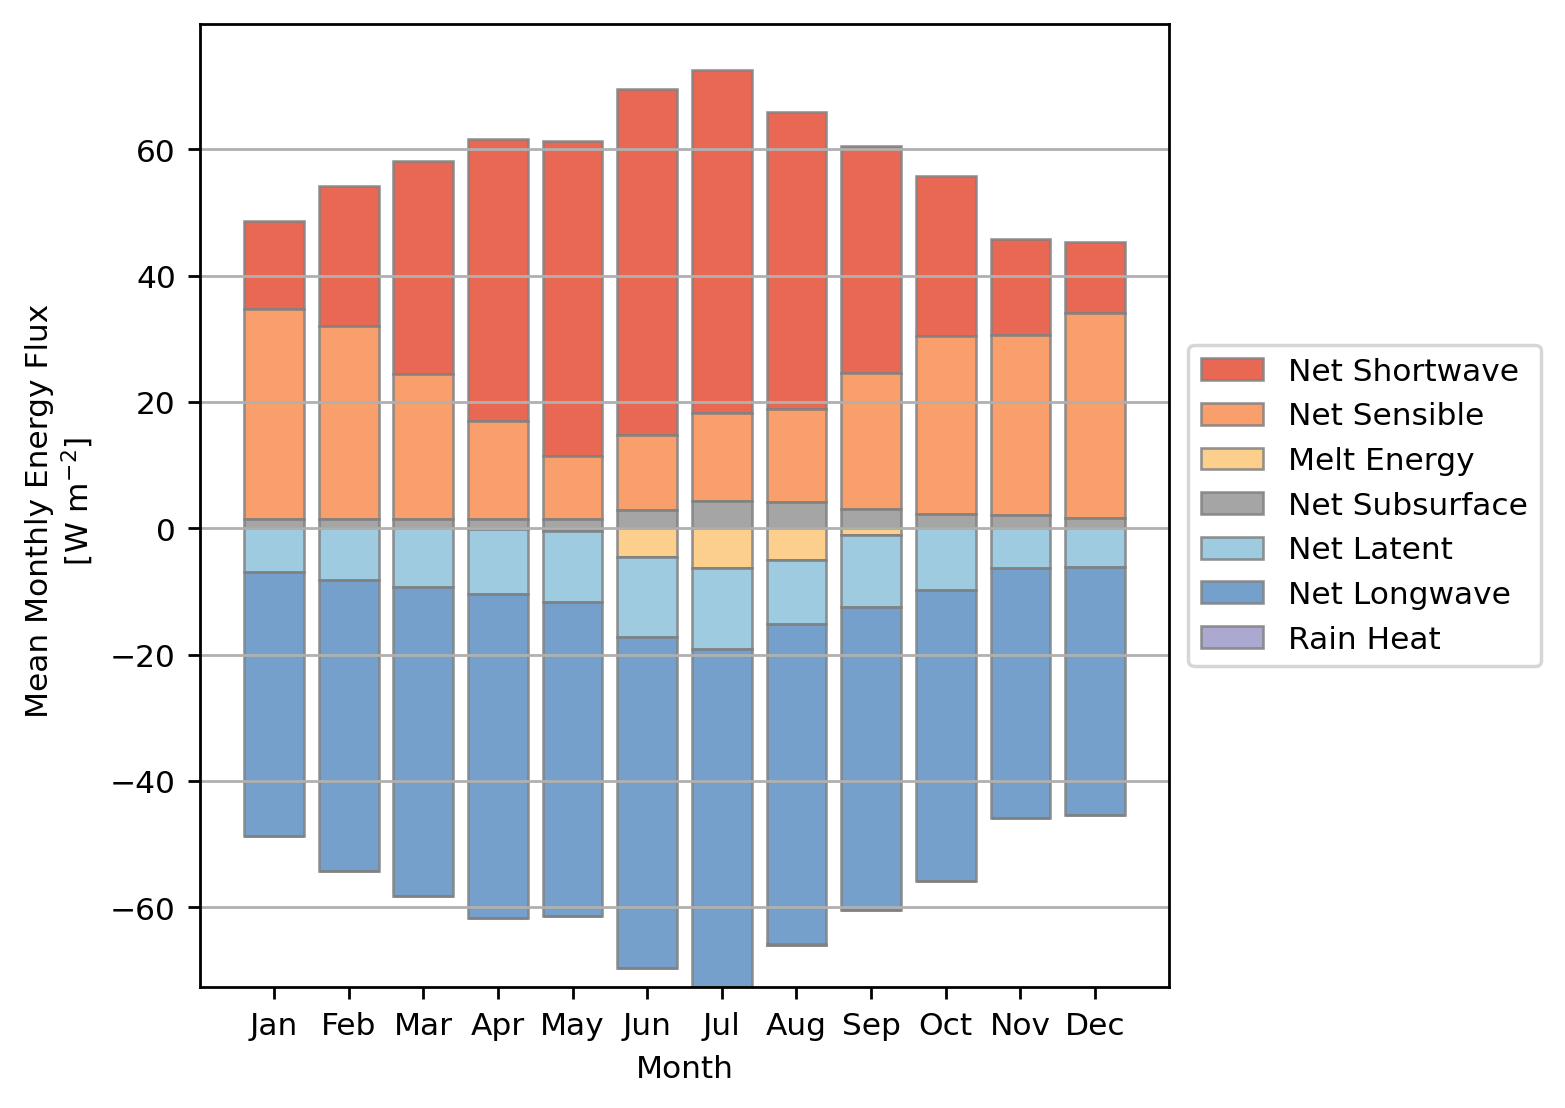

In [9]:
# Produces a point surface energy balance figure for a chosen dataset and spatial node (x,y):
create_point_surface_energy_balance_figure(ds, x, y)

## Point Surface Mass Balance (SMB)
Produces a graphical representation of the surface mass balance for a single spatial node (expressed as mean monthly mass fluxes).

In [10]:
def create_point_surface_mass_balance_figure(ds, x, y):
    """ Produces a graphical representation of the surface mass balance for a single spatial node 
    (expressed as mean monthly mass fluxes).
    
    Arguments:

        ds    ::    Loaded Xarray dataset (FRICOSIPY Output NetCDF file).
        x     ::    Easting (X-coordinate) of chosen spatial node.
        y     ::    Northing (Y-coordinate) of chosen spatial node.

    Returns:

        Figure: Point Surface Mass Balance (SMB)
    
    """

    # Calculate the mean annual mass fluxes:
    years = ds.time.dt.year.count()
    SNOWFALL = ds.SNOWFALL.sel(x = x, y = y).resample(time='ME').sum().groupby("time.month").mean("time").values * 100
    DEPOSITION = ds.DEPOSITION.sel(x = x, y = y).resample(time='ME').sum().groupby("time.month").mean("time").values * 100
    CONDENSATION = ds.CONDENSATION.sel(x = x, y = y).resample(time='ME').sum().groupby("time.month").mean("time").values * 100
    EVAPORATION = ds.EVAPORATION.sel(x = x, y = y).resample(time='ME').sum().groupby("time.month").mean("time").values * 100
    SUBLIMATION = ds.SUBLIMATION.sel(x = x, y = y).resample(time='ME').sum().groupby("time.month").mean("time").values * 100
    SURFACE_MELT = ds.SURFACE_MELT.sel(x = x, y = y).resample(time='ME').sum().groupby("time.month").mean("time").values * -100

    # Import colourmaps:
    RdYlGn = mpl.colormaps['RdYlGn']

    # Setup Figure & Axis:
    plt.rcParams.update({'font.size': 9})
    fig, ax = plt.subplots(1,1,figsize=(5,5), dpi = 250)
    ax.set(ylabel = "Mean Monthly Mass Flux \n [cm w.e.]", xlabel = "Month")
    ax.grid(visible=True, which='major', axis='y')

    # Bar Chart:
    months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    ax.bar(months, SNOWFALL, width = 0.7, color = RdYlGn(0.85), alpha = 0.85, edgecolor = "gray", linewidth = 0.75, bottom = CONDENSATION + DEPOSITION, label = "Snowfall")
    ax.bar(months, DEPOSITION, width = 0.7, color = RdYlGn(0.75), alpha = 0.85, edgecolor = "gray", linewidth = 0.75, bottom = CONDENSATION, label = "Deposition")
    ax.bar(months, CONDENSATION, width = 0.7, color = RdYlGn(0.65), alpha = 0.85, edgecolor = "gray", linewidth = 0.75, label = "Condensation")
    ax.bar(months, EVAPORATION, width = 0.7, color = RdYlGn(0.35), alpha = 0.85, edgecolor = "gray", linewidth = 0.75, label = "Evaporation")
    ax.bar(months, SUBLIMATION, width = 0.7, color = RdYlGn(0.25), alpha = 0.85, edgecolor = "gray", linewidth = 0.75, bottom = EVAPORATION, label = "Sublimation")
    ax.bar(months, SURFACE_MELT, width = 0.7, color = RdYlGn(0.15), alpha = 0.85, edgecolor = "gray", linewidth = 0.75, bottom = EVAPORATION + SUBLIMATION, label = "Surface Melt")

    # Figure Legend:
    plt.legend(loc="center right", bbox_to_anchor=(1.4,0.5));

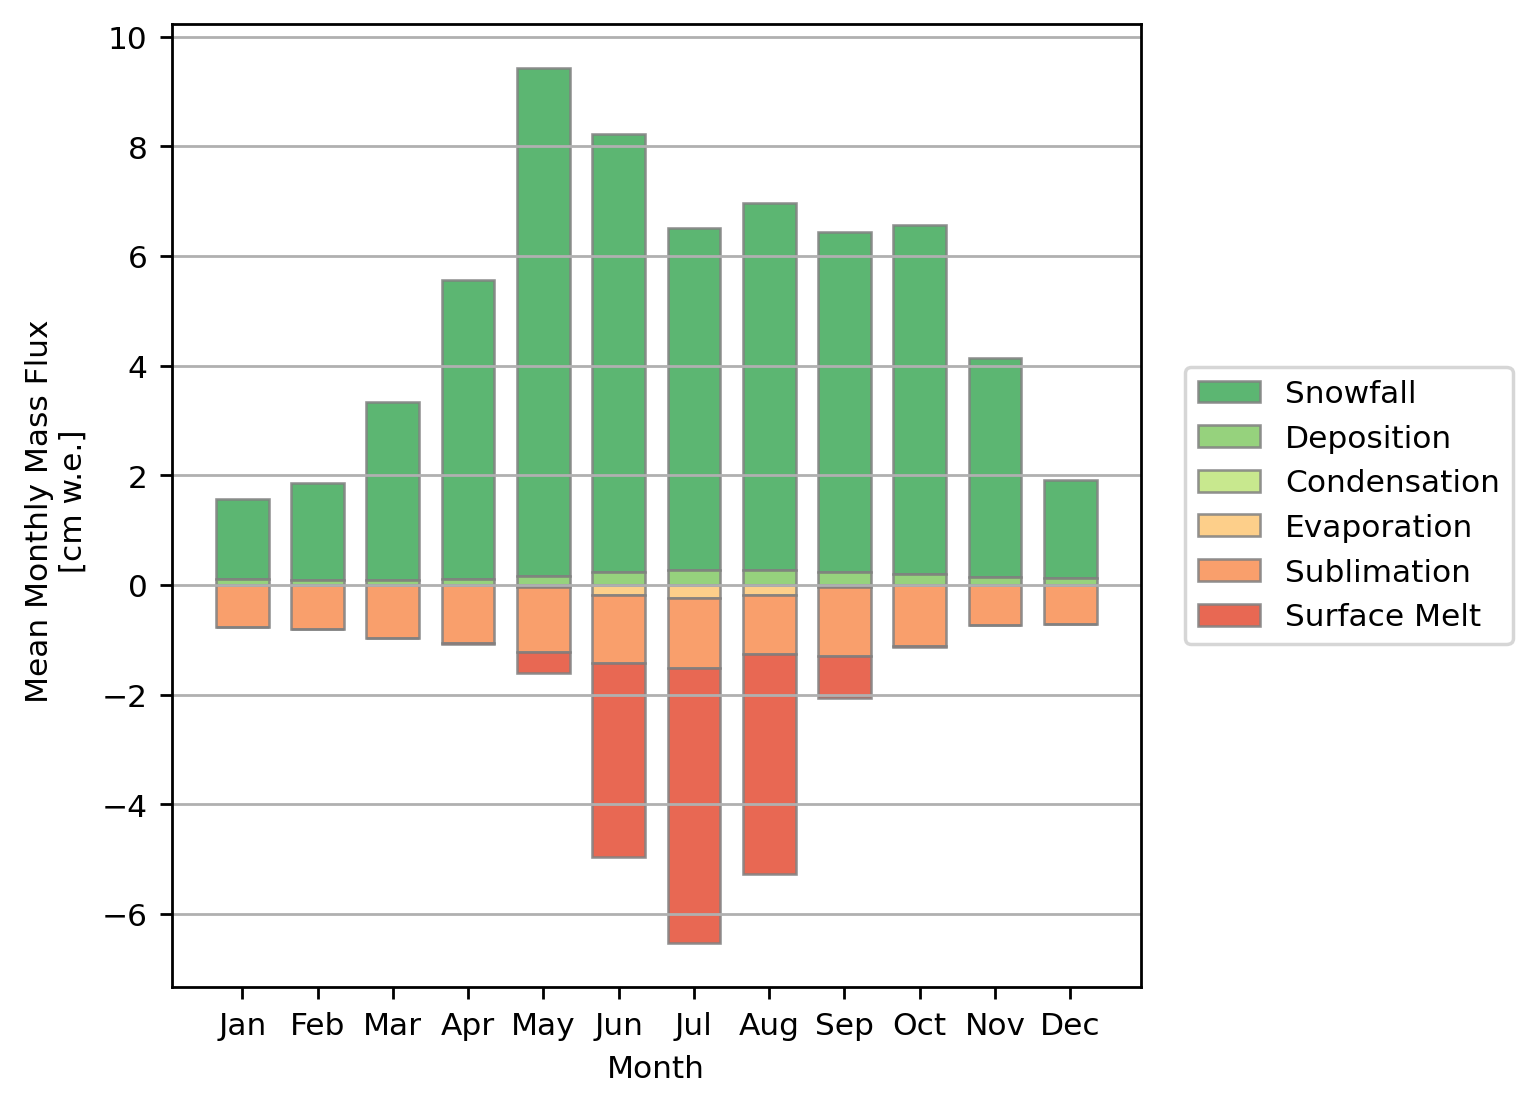

In [11]:
# Produces a point surface mass balance figure for a chosen dataset and spatial node (x,y):
create_point_surface_mass_balance_figure(ds, x, y)